# Analysis and model building

Showing some summary graphs and statistics for the Kumeu Weather data that will be used for weather forecasting. Historical hourly weather data is available from Jan 2016 til May 2021.

Goals to achieve:
1. Predict temperature
2. Export temperature model
3. Repeat steps 1 and 2 with variables: rainfall, humidity, windspeed

Task list:
- ✓ Import historic data
- ✓ Plot graphs to view data
- ✓ Format and export historic data as csv
- ✓ Format and export historic data as DataFrame (in pickle format) 
- ✓ Encode and standardise data to prepare for model training
- ✓ Export standardised model data as csv and DataFrame (pickle format)
- To do: Bulid model with correct parameters
- To do: Train model
- To do: Evaluate model
- <b> At this stage, the model is ready to be exported as an initial proof of concept for the prediction app</b>
- To do: Build, train and evaluate models with different architectures for model selection
- To do: Hyperparameter tuning to improve the selected model
- To do: Critically analyse the strengths and weaknesses of the model and predictions
- To do: Repeat all steps for the variables: rainfall, humidity, windspeed

## Preliminaries: Install and import necessary libraries

%%capture
# Install and import libraries. %%capture is used to suppress messages for library install statuses

import sys

!{sys.executable} -m pip install -r requirements.txt


In [1]:
import os, random, csv, re
import pandas as pd
import numpy as np
import scipy.optimize as opt
import plotly.express as px
import plotly.offline as pyo
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Activation, RepeatVector, TimeDistributed
from keras.optimizers import Adam

# Suppress Tensorflow warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

# displays full numbers in dataframes instead of scientific notation for clarity
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_columns', 500)

# For model building/training
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


## Import historic hourly Kumeu weather data

In [2]:
data_dir = """../kumeu-rainfall/data/Weather Station Hourly/"""

input_data_paths = [data_dir+"MetWatch Export (20{}).csv".format(i) for i in range(16,22)]
input_data_paths

['../kumeu-rainfall/data/Weather Station Hourly/MetWatch Export (2016).csv',
 '../kumeu-rainfall/data/Weather Station Hourly/MetWatch Export (2017).csv',
 '../kumeu-rainfall/data/Weather Station Hourly/MetWatch Export (2018).csv',
 '../kumeu-rainfall/data/Weather Station Hourly/MetWatch Export (2019).csv',
 '../kumeu-rainfall/data/Weather Station Hourly/MetWatch Export (2020).csv',
 '../kumeu-rainfall/data/Weather Station Hourly/MetWatch Export (2021).csv']

In [3]:
input_data = []

for data_path in input_data_paths:
    csv_list = []
    with open(data_path) as f:
        next(f)
        next(f)
        for line in f.readlines():
            if ',' in line:
                input_data.append(line.strip().split(','))

for i in range(len(input_data)):
    if len(input_data[i])<2:
        input_data[i] = None
        continue
    else:
        date_split = input_data[i][0].split(' ')[1:]
        date_split[0] = re.sub('[a-zA-Z]+','',date_split[0])
        date_split[-1] = date_split[-1].strip('"')
        input_data[i][0] = " ".join(date_split)
        if (len(input_data[i])>1):
            input_data[i][1] = input_data[i][1].strip('"')
            input_data[i][8] = input_data[i][8].strip('"')
        for j in range(1,len(input_data[i])):
            if input_data[i][j] == '':
                input_data[i][j] = None
            elif input_data[i][j] == '-':
                input_data[i][j] = None

## Preprocessing
Import data as Data Frame, tidy up column names and null values in data. Convert time series data into DateTime formats (day, month, year, hour).

In [4]:
raw_df = pd.DataFrame(data=input_data, columns=['date','time_hourly','temp_C','rain_mm','wetness_percent','rel_humidity_percent',
                                 'wind_speed_kmph','wind_direction','spray_drift_risk','backup_data','missing_data'])

raw_df = raw_df.astype(dtype={'date':'object','time_hourly':'object','temp_C':'float64','rain_mm':'float64',
                                  'wetness_percent':'float64','rel_humidity_percent':'float64',
                                  'wind_speed_kmph':'float64','wind_direction':'object','spray_drift_risk':'object',
                                  'backup_data':'float64','missing_data':'object'})

In [5]:
raw_df['max_hour_str'] = raw_df['time_hourly'].str.split('-').str[-1].str.strip() 
raw_df['datetime_mid']= pd.to_datetime(raw_df['date'] + raw_df['max_hour_str'], format='%d %b %Y%I%p') - pd.Timedelta(minutes=30)
raw_df['end_hour'] = pd.to_datetime(raw_df['max_hour_str'], format='%I%p').dt.hour
raw_df['start_hour'] = raw_df['end_hour'] - 1
raw_df['day'] = raw_df['datetime_mid'].dt.day
raw_df['month'] = raw_df['datetime_mid'].dt.month
raw_df['year'] = raw_df['datetime_mid'].dt.year

train_df = raw_df[['datetime_mid','temp_C','rain_mm','wetness_percent','rel_humidity_percent','wind_speed_kmph','wind_direction','spray_drift_risk','backup_data','missing_data','year','month','day','start_hour','end_hour']]
train_df = train_df.set_index('datetime_mid')
train_df.sample(2)

,temp_C,rain_mm,wetness_percent,rel_humidity_percent,wind_speed_kmph,wind_direction,spray_drift_risk,backup_data,missing_data,year,month,day,start_hour,end_hour
datetime_mid,,,,,,,,,,,,,,
2016-08-25 18:30:00,14.000000,2.200000,93.300000,100.000000,3.700000,NE,Not Recommended,NaN,None,2016,8,25,18,19
2018-09-09 04:30:00,9.400000,0.000000,0.300000,78.800000,3.600000,SW,Best Conditions,NaN,None,2018,9,9,4,5


## Checkpoint: save data
The input weather data is now formatted. Output as csv and pickle file.
The pickle file (.pkl) is a copy of the pre-processed DataFrame so you don't need to repeat the steps above.

Import by using the code: `pd.read_pickle(file path to the pickle file)`

train_df.to_csv('../kumeu-rainfall/data/hourly_2016_2021.csv')
train_df.to_pickle('../kumeu-rainfall/data/hourly_2016_2021.pkl')

## Graphs
Visual graph of temperature data. Data appears seasonal a high level (year and month level). Seasonality patterns are not as strong, and there are some irregularities when looking at temperature on the granular hourly level.

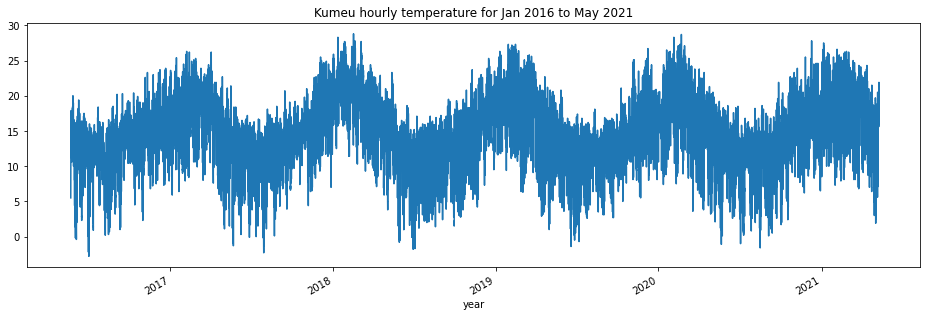

In [6]:
total_temp_plot = train_df['temp_C'].plot(figsize=(16,5),title='Kumeu hourly temperature for Jan 2016 to May 2021',xlabel='year')

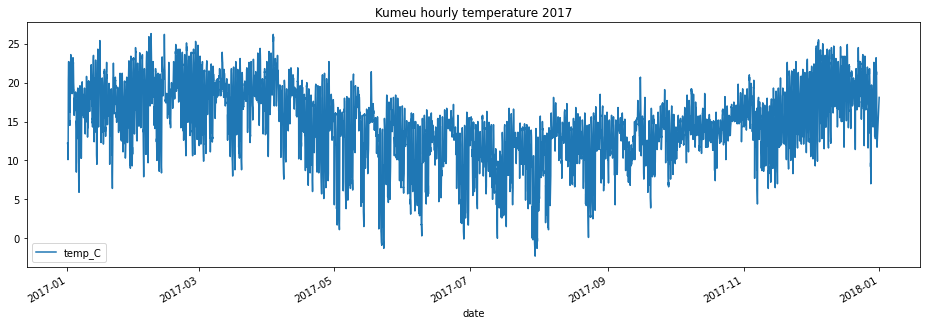

In [7]:
temp_2017 = train_df[['temp_C']].loc[train_df.index.year==2017].plot(figsize=(16,5),title='Kumeu hourly temperature 2017',xlabel='date')

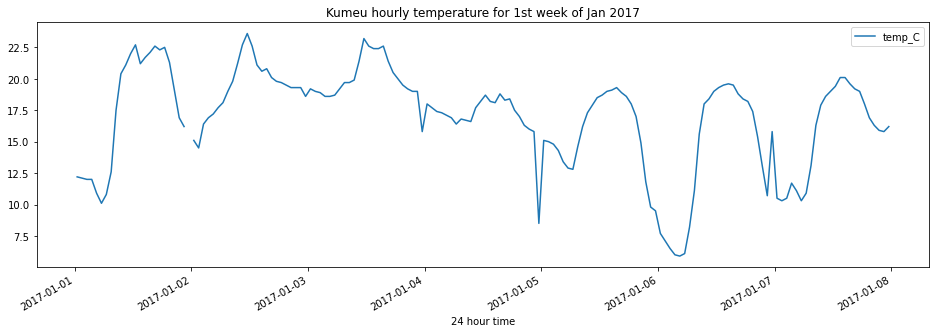

In [8]:
temp_1week = train_df[['temp_C']].loc[(train_df.index.year==2017) & (train_df.index.month==1) & (train_df.index.day<8)].plot(figsize=(16,5),title='Kumeu hourly temperature for 1st week of Jan 2017',xlabel='24 hour time')

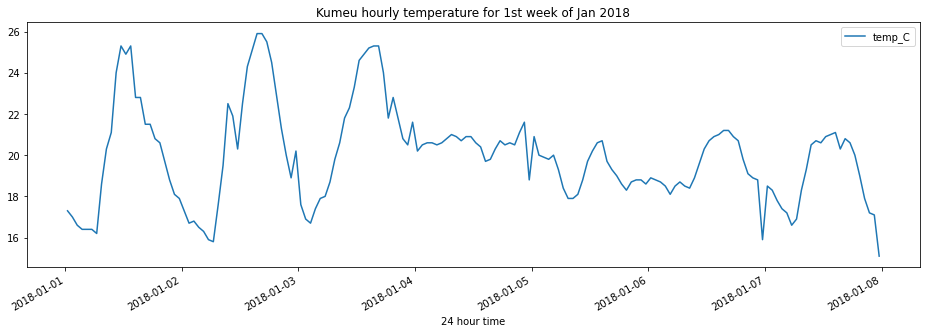

In [9]:
temp_1week = train_df[['temp_C']].loc[(train_df.index.year==2018) & (train_df.index.month==1) & (train_df.index.day<8)].plot(figsize=(16,5),title='Kumeu hourly temperature for 1st week of Jan 2018',xlabel='24 hour time')

## Preparing data for model training

The data needs to be transformed before it can be input into a neural network model. The following steps are taken in this section:

- One Hot Encoding
- Standardised scaling

In [10]:
train_df.drop(labels=['year','month','day','start_hour','end_hour','backup_data','spray_drift_risk','missing_data'], axis=1, inplace=True)

train_df_encoded = pd.get_dummies(train_df, drop_first=True)
#put temperature at the end of the dataframe because that will be the label - the value we are trying to predict
train_df_encoded = train_df_encoded[['rain_mm','wetness_percent','rel_humidity_percent','wind_speed_kmph',
                                    'wind_direction_N','wind_direction_NE','wind_direction_NW','wind_direction_S',
                                    'wind_direction_SE','wind_direction_SW','wind_direction_W','temp_C']]

In [11]:
train_df_encoded.sample(5)

,rain_mm,wetness_percent,rel_humidity_percent,wind_speed_kmph,wind_direction_N,wind_direction_NE,wind_direction_NW,wind_direction_S,wind_direction_SE,wind_direction_SW,wind_direction_W,temp_C
datetime_mid,,,,,,,,,,,,
2017-01-27 08:30:00,0.000000,33.900000,79.100000,6.100000,0,0,0,0,0,1,0,17.000000
2019-11-30 22:30:00,0.000000,97.000000,91.800000,0.200000,0,1,0,0,0,0,0,15.200000
2016-07-03 04:30:00,0.000000,11.500000,100.000000,0.000000,0,0,0,0,0,0,1,-1.900000
2016-11-17 14:30:00,0.000000,6.500000,68.400000,23.600000,0,0,0,0,0,1,0,16.200000
2018-02-13 14:30:00,0.000000,3.800000,95.800000,5.200000,0,1,0,0,0,0,0,23.800000


In [12]:
train_df_encoded_scaled = pd.DataFrame(StandardScaler().fit_transform(train_df_encoded))

In [13]:
train_df_encoded_scaled.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
13956,-0.171666,-1.014628,-1.578038,0.939847,-0.460656,2.395087,-0.250221,-0.193027,-0.164930,-0.667546,-0.383658,-0.096723
42928,-0.171666,-0.672692,-0.868213,1.567367,-0.460656,-0.417521,-0.250221,-0.193027,-0.164930,1.498024,-0.383658,0.649945
32416,-0.171666,-1.033111,-1.223125,0.511297,-0.460656,-0.417521,-0.250221,-0.193027,-0.164930,1.498024,-0.383658,0.165620
22551,-0.171666,-1.033111,-2.975959,0.082747,-0.460656,-0.417521,-0.250221,-0.193027,-0.164930,-0.667546,-0.383658,0.004178
17798,-0.171666,-1.035421,-1.462148,0.893931,-0.460656,2.395087,-0.250221,-0.193027,-0.164930,-0.667546,-0.383658,2.163461


## Checkpoint: save data

The input data is now formatted for neural network implementation. The data is saved as a csv file and also a pickle file. The pickle file can be loaded directly into a Python script so that you can skip all the above steps and start working directly with the data formatted for model implementation.

Code to import pickle file:
`pd.read_pickle(file path to the pickle file)`

In [ ]:
train_df_encoded_scaled.to_csv('../kumeu-rainfall/data/hourly_2016_2021_encoded_scaled.csv')
train_df_encoded_scaled.to_pickle('../kumeu-rainfall/data/hourly_2016_2021_encoded_scaled.pkl')

## Checkpoint: load data

Load the numpy array that is prepared for neural network implementation

In [15]:
train_df_encoded_scaled = pd.read_pickle('../kumeu-rainfall/data/hourly_2016_2021_encoded_scaled.pkl')

In [16]:
# Only train on temperature, humidity and wind speed
#train_df_encoded_scaled =train_df_encoded_scaled[[11,2,3]]
train_df_encoded_scaled = train_df_encoded_scaled.to_numpy()

train_df_encoded_scaled

array([[        nan,         nan,         nan, ..., -0.66754596,
        -0.38365814,         nan],
       [        nan,         nan,         nan, ..., -0.66754596,
        -0.38365814,         nan],
       [        nan,         nan,         nan, ..., -0.66754596,
        -0.38365814,         nan],
       ...,
       [-0.17166618,  1.20333281,  0.68905635, ..., -0.66754596,
         2.60648709,  0.58940447],
       [-0.17166618,  1.20333281,  0.74700125, ..., -0.66754596,
        -0.38365814,  0.56922427],
       [-0.17166618,  0.96305375,  0.74700125, ..., -0.66754596,
         2.60648709,  0.58940447]])

In [ ]:
#X = train_df_encoded_scaled[:,:-1]
#y = train_df_encoded_scaled[:,-1]
#X.shape, y.shape

## Train/test data split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=24, max_train_size=72, test_size=12)
print(tscv)

In [ ]:
trainX = []
trainY = []

for train_index, test_index in tscv.split(train_df_encoded_scaled):
    print("TRAIN:", train_index, "TEST:", test_index)
    trainX.append(train_df_encoded_scaled[train_index])
    trainY.append(train_df_encoded_scaled[test_index])
    #X_train, X_test = trainX[train_index], trainX[test_index]
    #y_train, y_test = trainY[train_index], trainY[test_index]

In [81]:
# @author: Sreenivas Bhattiprolu
    
# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 2. We will make timesteps = 3. 
# With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

n_future = 24   # Number of days we want to predict into the future
n_past = 24     # Number of past days we want to use to predict the future

# step=48
# for i in range(0, len(train_df_encoded_scaled), step):
#     mid_index = int((i + step)/2)
#     end_index = int(i + step)
#     trainX.append(train_df_encoded_scaled[i:mid_index,i:mid_index])
#     trainY.append(train_df_encoded_scaled[mid_index:end_index,mid_index:end_index])
    
for i in range(n_past, len(train_df_encoded_scaled) - n_future +1):
    trainX.append(train_df_encoded_scaled[i - n_past:i, 0:train_df_encoded_scaled.shape[1]])
    trainY.append(train_df_encoded_scaled[i + n_future - 1:i + n_future,0:train_df_encoded_scaled.shape[1]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape: {}.'.format(trainX.shape))
print('trainY shape: {}.'.format(trainY.shape))


trainX shape: (46778, 24, 12).
trainY shape: (46778, 1, 12).


## Build model

In [105]:
# define Autoencoder model
from keras.layers import Dense, Dropout, LSTM, Embedding, Activation, RepeatVector, TimeDistributed

model = Sequential(name='lstm')

model.add(LSTM(trainX.shape[2], activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True, name = 'lstm1'))
model.add(LSTM(100, activation='relu', return_sequences=False, name='lstm2'))
model.add(Dense(100, name='dense'))
model.add(Activation(activation='relu', name='activation'))
model.add(RepeatVector(n=24, name = 'repeat'))
model.add(LSTM(100, activation='relu', return_sequences=True, name='lstm3'))
model.add(TimeDistributed(Dense(trainX.shape[2]), name='timedistributed'))

model.compile(optimizer='adam', loss='mse')


opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)

model.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 24, 12)            1200      
_________________________________________________________________
lstm2 (LSTM)                 (None, 100)               45200     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
repeat (RepeatVector)        (None, 24, 100)           0         
_________________________________________________________________
lstm3 (LSTM)                 (None, 24, 100)           80400     
_________________________________________________________________
timedistributed (TimeDistrib (None, 24, 12)            1212   

## Train model



In [106]:
# fit model
history = model.fit(trainX, trainY, 
                    epochs=3,batch_size=64,
                    validation_data=0.1, 
                    verbose=1)

Epoch 1/3


ValueError: Shapes (64, 1, 12) and (64, 24, 12) are incompatible

In [80]:
# Example LSTM - this is just an example, it doesn't forecast weather well
# define Autoencoder model

# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 64)            19712     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
# history = model.fit(trainX, trainY, 
#                     epochs=3, batch_size=24, 
#                     validation_data=0.1, 
#                     verbose=1)